## There are two crucial stages for this bit. 

#### Firstly we need to be able to get the letters from the identity into their own boxes. Here you see an example, but its not so robust right now. 
#### Then we take 2 models trained, one trained on the relevant letters and one trained on the numbers (there are good publically available datasets) and predict. 

In [1]:
from google.cloud import vision
from google.cloud import storage
from PIL import Image
import numpy as np
import os, sys
from image import *
import csv  
from io import BytesIO
from IPython import display

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"../guppies-test-4c48569421d8.json"

import torch
import cv2
import matplotlib.pyplot as plt

from skimage.transform import rotate
from skimage.draw import polygon

import scipy


In [2]:
def extract_vertices(bounding_box):
    vertices = []
    for vertex in bounding_box.vertices:
        vertices.append((vertex.x, vertex.y))
    return vertices



def GetImageAndParaBox(file, client, verbose=False):
    '''
    retrieve the image along with a box that includes the ID.
    '''

    image = RetreiveImage(file, verbose=False)


    img_byte_array = CroppedImage(image, verbose=False)

    decoded = np.fromstring(img_byte_array.getvalue(), dtype=np.uint8)
    frame = cv2.imdecode(decoded, cv2.IMREAD_COLOR) 


    content = img_byte_array.getvalue()
    image = vision.Image(content=content)

    response = client.document_text_detection(image=image, image_context={"language_hints": ["en"]})
    
    character = []
    character_params = []

    charno = 0
    for a, page in enumerate(response.full_text_annotation.pages):
        for b, block in enumerate(page.blocks):

            for c, paragraph in enumerate(block.paragraphs):
                
                for d, word in enumerate(paragraph.words):
                    for e, symbol in enumerate(word.symbols):

                        character.append(symbol.text)

                        charno += 1

                        character_params.append([a, b, c, d, e])


                        if verbose: print(character[-1], 'pageno:'+str(a), 'blockno:'+str(b), 'paragraphno:'+str(c), 'wordno:'+str(d), 'symbolno:'+str(e))


    character_params = np.array(character_params)

    if len(np.unique(character_params[:,2])) != 1: #if theres more than one paragraph, then the ID is split across >2 words.
        
            page_no, block_no, paragraph_no, word_no, symbol_no = character_params[5] #take the 5th character and use the words boudning box.

            para_boxes = np.array([np.array(extract_vertices(page.blocks[block_no].paragraphs[paragraph_no].words[i].bounding_box)) for i in range(len(page.blocks[block_no].paragraphs[paragraph_no].words))])
            para_box = combine_paraboxes(para_boxes)

    else:
        no_words = len(np.unique(character_params[:,3]))
        if no_words==3:
            page_no, block_no, paragraph_no, word_no, symbol_no = character_params[5] #take the 5th character and use the words boudning box.

            para_box = np.array(extract_vertices(page.blocks[block_no].paragraphs[paragraph_no].words[word_no].bounding_box))
        

        else: #this means that the ID has been split across two words annoyingly.


            #discard title and date
            character_params = character_params[(character_params[:,3]!=0) & (character_params[:,3]!=np.max(character_params[:,3]))] 
            
            uniwords = np.unique(character_params[:,3])

            para_boxes = np.array([np.array(extract_vertices(page.blocks[character_params[0,1]].paragraphs[character_params[0,2]].words[uniwords[i]].bounding_box)) for i in range(len(uniwords))])


            #now need to combine the words. 
            if not all(np.abs(para_boxes[0,:,1] - para_boxes[1,:,1]) < 200): #check the y coordinates
                raise ValueError('check they are actually same word.')
            
            para_box = combine_paraboxes(para_boxes)

    return frame, para_box


def combine_paraboxes(para_boxes):
    bottom_left = para_boxes[:,0]
    bottom_right = para_boxes[:,1]
    top_right = para_boxes[:,2]
    top_left = para_boxes[:,3]

    para_box = np.zeros((4,2), dtype=np.int32)

    para_box[0] = np.min(bottom_left, axis=0)
    para_box[1] = np.max(bottom_right[:,0]),np.min(bottom_right[:,1])
    para_box[2] = np.max(top_right,axis=0)
    para_box[3] = np.min(top_left[:,0]),np.max(top_left[:,1])

    return para_box

def rotate_image_and_transform_coordinates(image, coordinates, angle):

    angle = np.rad2deg(angle)

    # Calculate the transformation matrix.
    transform_matrix = cv2.getRotationMatrix2D((image.shape[1] // 2, image.shape[0] // 2), angle, 1)

    # Apply the transformation matrix to the coordinates.
    image = cv2.warpAffine(image, transform_matrix, (image.shape[1], image.shape[0]))

    transformed_coordinates = [(transform_matrix[:,:2] @ coordinates[i].T).T + transform_matrix[:,2] for i in range(len(coordinates))]

    return image, transformed_coordinates

def zero_printed_text(image, threshold=40, verbose=False):

    mask = np.zeros(image.shape, dtype=np.uint8)

    mask[(image>0) & (image<threshold)] = 1

    nx, ny = image.shape

    # mask[nx//6:4*nx//6, ny//6:5*ny//6] = 0 #havent worked this bit out yet

    dilated = cv2.dilate(mask, np.ones((9,9), np.uint8), iterations=1)



    return image * (1-dilated)


In [3]:
def extract_ID_handwriting(frame, paragraph_vertices, verbose=False):
        
    padx = 100
    pady = 60

    #firstly find the box around the identity, and also calculate the approx angle of rotation of that box. 
    adapted_para_box = paragraph_vertices.copy()

    x = np.argsort(paragraph_vertices[:,0])
    y = np.argsort(paragraph_vertices[:,1])

    adapted_para_box[x[:2],0] = paragraph_vertices[x[:2],0] - padx
    adapted_para_box[x[2:],0] = paragraph_vertices[x[2:],0] + 1.2*padx

    adapted_para_box[y[:2],1] = paragraph_vertices[y[:2],1] - pady
    adapted_para_box[y[2:],1] = paragraph_vertices[y[2:],1] + pady

    rel_area = polygon(adapted_para_box[:,1], adapted_para_box[:,0]) 
    mask1 = np.zeros(frame.shape[:2], dtype=np.uint8)
    mask1[rel_area] = 1

    miny, maxy, minx, maxx = np.min(adapted_para_box[:,0]), np.max(adapted_para_box[:,0]), np.min(adapted_para_box[:,1]), np.max(adapted_para_box[:,1])


    idx = paragraph_vertices[:,1].argsort()[:2]
    dx = paragraph_vertices[idx[1],0] - paragraph_vertices[idx[0],0]
    dy = paragraph_vertices[idx[1],1] - paragraph_vertices[idx[0],1]

    angle = np.arctan2(dy,dx)


    if verbose:
        fig,ax = plt.subplots(1,5,dpi=250)
        ax[0].imshow(frame)
    frame = frame*mask1[...,None] #mask the image

    if verbose: ax[1].imshow(frame)

    frame = np.mean(frame, axis=2)
    frame = frame[minx:maxx, miny:maxy]

    if verbose: ax[2].imshow(frame)

    frame = rotate(frame, -angle, resize=False, ) #rotate the image
    # frame = (1-frame) #invert and threshold.
    # frame[frame < 0.5] = 0
    # frame[frame !=0] = 1

    if verbose: ax[3].imshow(frame)


    frame = zero_printed_text(frame, threshold = 30) #threshold needs to be found algorithmically.


    hist = np.histogram(frame, bins=100)
    peaks,_ = scipy.signal.find_peaks(hist[0], height=1000, distance=7)

    if len(peaks) == 2:
        peak_handwriting = peaks[0]
        peak_background = peaks[1]

        thresh = 1*hist[1][peak_background]/4  + 3*hist[1][peak_handwriting]/4
    else:
        thresh = frame.max()*0.85
        


    frame[frame>thresh] = 0 
    frame[frame!=0] = 1

    if verbose: ax[4].imshow(frame)


    return frame


C:\Users\howards\AppData\Local\Temp\ipykernel_16356\3490466190.py:19: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  decoded = np.fromstring(img_byte_array.getvalue(), dtype=np.uint8)


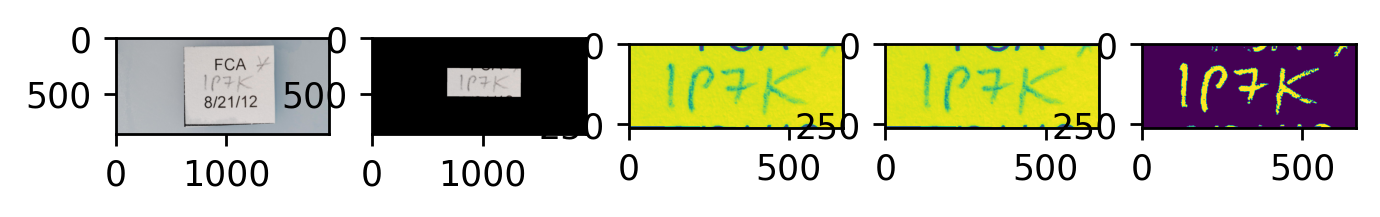

In [4]:
file = 'Manually_Labelled/CA1208/FCA1P7K1208s.JPG'
client = vision.ImageAnnotatorClient()
frame, para_box = GetImageAndParaBox(file, client)

%matplotlib inline
ID = extract_ID_handwriting(frame, para_box, verbose=True)

In [5]:
folder = 'Manually_Labelled/CA1206'
bucket_name = "guppy_images"
storage_client = storage.Client()
bucket = storage_client.bucket(bucket_name)

file_list = storage_client.list_blobs(bucket_name,prefix=folder)
file_list = [file.name for file in file_list]

In [6]:
file_list[0]

'Manually_Labelled/CA1206/FCA106W1206.JPG'

In [7]:
def extract_ID(file_list):
    
    id_list = []
    for f in file_list:
        f = f.split('/')[-1].split('.')[0]

        title = f[:3]
        date = f[-4:]
        id = f[3:-4]
        id_list.append(id)

    return id_list

In [8]:
IDs = np.array(extract_ID(file_list))

C:\Users\howards\AppData\Local\Temp\ipykernel_16356\3490466190.py:19: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  decoded = np.fromstring(img_byte_array.getvalue(), dtype=np.uint8)


F pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:0
C pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:1
A pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:2
1 pageno:0 blockno:0 paragraphno:0 wordno:1 symbolno:0
0 pageno:0 blockno:0 paragraphno:0 wordno:1 symbolno:1
3 pageno:0 blockno:0 paragraphno:0 wordno:1 symbolno:2
w pageno:0 blockno:0 paragraphno:0 wordno:2 symbolno:0
6 pageno:0 blockno:0 paragraphno:0 wordno:3 symbolno:0
/ pageno:0 blockno:0 paragraphno:0 wordno:3 symbolno:1
2 pageno:0 blockno:0 paragraphno:0 wordno:3 symbolno:2
1 pageno:0 blockno:0 paragraphno:0 wordno:3 symbolno:3
/ pageno:0 blockno:0 paragraphno:0 wordno:3 symbolno:4
1 pageno:0 blockno:0 paragraphno:0 wordno:3 symbolno:5
2 pageno:0 blockno:0 paragraphno:0 wordno:3 symbolno:6


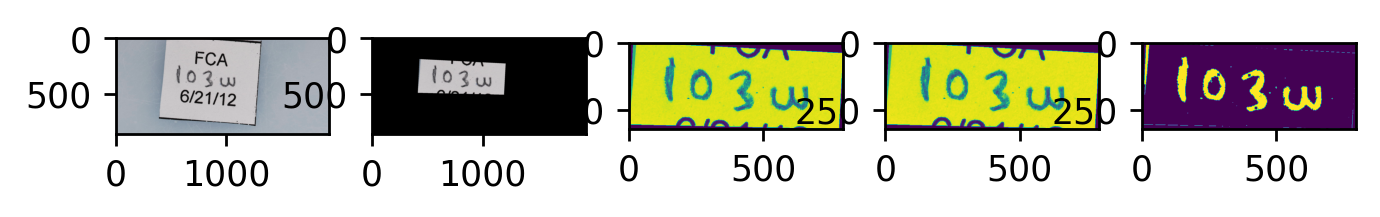

In [9]:
frame, para_box = GetImageAndParaBox(file_list[12], client = client, verbose=True)

im_ID = extract_ID_handwriting(frame, para_box, verbose=True)


In [10]:
some_im_IDs = []
some_label_IDs = []

idx = np.arange(0, len(file_list))
np.random.shuffle(idx)


for i in range(10):
    st = str(i)
    try: 
        frame, para_box = GetImageAndParaBox(file_list[idx[i]], client = client, verbose=False)
        im_ID = extract_ID_handwriting(frame, para_box, verbose=False)
        some_im_IDs.append(im_ID)
        some_label_IDs.append(IDs[idx[i]])
        st += ' success'

    except: st += ' fail'
    print(st)


    

C:\Users\howards\AppData\Local\Temp\ipykernel_16356\3490466190.py:19: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  decoded = np.fromstring(img_byte_array.getvalue(), dtype=np.uint8)


0 success
1 success
2 success
3 fail
4 fail
5 success
6 success
7 success
8 fail
9 success


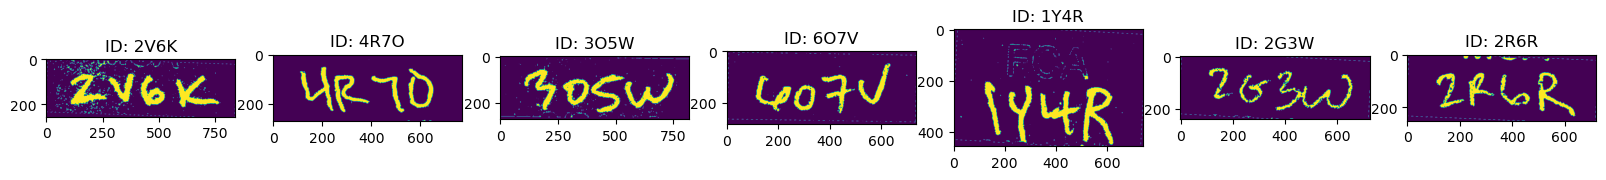

In [11]:

fig,ax = plt.subplots(1,len(some_im_IDs), figsize=(20,20))


for i in range(len(some_im_IDs)):
    ax[i].imshow(some_im_IDs[i])
    ax[i].set_title('ID: %s' %some_label_IDs[i])




In [12]:
# frame, para_box = GetImageAndParaBox(file_list[idx[0]], client = client, verbose=True)

# im_ID = extract_ID_handwriting(frame, para_box, verbose=True)
